In [ ]:
!pip install sentence-transformers

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import os
import pickle
import random
import math
import joblib

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
os.environ["WANDB_DISABLED"] = "true"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
# Data
train_path = "../Dataset/Augmented/train_augmented_Swap.csv"
test_path = "../Dataset/valid.csv"
MODEL_PATH = "../BERT_CL"
DICT_PATH = f"{MODEL_PATH}/embeddings_dictionary.pkl"

# Model
MODEL_NAME = "bert-large-uncased"
BATCH_SIZE = 16
N_EPOCHS = 5

# Reproducibility
SEED = 42
set_seed(SEED)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device selected: {device}")

Device selected: cuda


In [7]:
df_train = pd.read_csv(train_path).dropna(subset=['text', 'label', 'task', 'variety'])
print(f"Train rows: {len(df_train)}")
df_test = pd.read_csv(test_path)
print(f"Test rows: {len(df_test)}")

Train rows: 35520
Test rows: 2428


## Lingue separate

In [ ]:
# Trainig function
def train_specific_model(task, variety, subset_df):
    model_name_id = f"{task}_{variety}".replace(" ", "_")
    output_path = f"{MODEL_PATH}/{model_name_id}"

    print(f"\nTraining: TASK={task.upper()} | VARIETY={variety.upper()}")
    print(f"Samples: {len(subset_df)}")

    df_train, df_val = train_test_split(subset_df, test_size=0.1, random_state=42, stratify=subset_df['label'])

    # Creating dataset for contrastive learning
    train_examples = []
    for i, row in subset_df.iterrows():
        train_examples.append(InputExample(texts=[row['text']], label=int(row['label'])))

    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

    word_embedding_model = models.Transformer(MODEL_NAME)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # Loss
    train_loss = losses.BatchHardTripletLoss(model=model)

    # Training
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        #evaluator=evaluator,
        epochs=N_EPOCHS,
        #evaluation_steps=EVAL_STEPS,
        warmup_steps=int(len(train_dataloader) * 0.01),
        output_path=output_path,
        save_best_model=True,
        show_progress_bar=True
    )

    print(f"Model saved in: {output_path}")
    return output_path

In [ ]:
tasks = df_train['task'].unique()
varieties = df_train['variety'].unique()

trained_models = {}

for task in tasks:
    for variety in varieties:
        subset = df_train[
            (df_train['task'] == task) &
            (df_train['variety'] == variety)
        ]

        # Start training
        path = train_specific_model(task, variety, subset)
        trained_models[f"{task}|{variety}"] = path

print("\nEnd training")


Training: TASK=SARCASM | VARIETY=EN-UK
Samples: 2062


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-large-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,5.604313


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved in: /content/drive/MyDrive/DNLP project - Figurative Language Understanding/BERT_CL/no_Google/Sarcasm_en-UK

Training: TASK=SARCASM | VARIETY=EN-AU
Samples: 3526


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-large-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,5.496244
1000,5.122926


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved in: /content/drive/MyDrive/DNLP project - Figurative Language Understanding/BERT_CL/no_Google/Sarcasm_en-AU

Training: TASK=SARCASM | VARIETY=EN-IN
Samples: 3372


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-large-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,5.716289
1000,4.561755


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved in: /content/drive/MyDrive/DNLP project - Figurative Language Understanding/BERT_CL/no_Google/Sarcasm_en-IN

End training


In [ ]:
# Dictionary to save all organized embeddings
# Structure: all_embeddings[task][variety] = matrice_numpy
all_embeddings = {}

print("\nEmbeddings generation")

for key, model_path in trained_models.items():
    task, variety = key.split("|")

    if task not in all_embeddings:
        all_embeddings[task] = {}

    model = SentenceTransformer(model_path)

    subset = df_train[(df_train['task'] == task) & (df_train['variety'] == variety)]
    texts = subset['text'].tolist()
    labels = subset['label'].tolist()

    emb = model.encode(texts, show_progress_bar=True)

    all_embeddings[task][variety] = {
        "X": emb,           # vectors
        "y": np.array(labels), # labels
        "texts": texts      # original text
    }
    print(f"{task}-{variety}: generated {len(emb)} embeddings.")

# Saving the entire dictionary to a pickle file
with open(DICT_PATH, "wb") as f:
    pickle.dump(all_embeddings, f)

print("All embeddings saved")


Embeddings generation


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

Sarcasm-en-UK: generated 2062 embeddings.


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

Sarcasm-en-AU: generated 3526 embeddings.


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

Sarcasm-en-IN: generated 3372 embeddings.
All embeddings saved


### Plots

In [8]:
print("Loading embeddings...")
with open(DICT_PATH, "rb") as f:
    all_embeddings = pickle.load(f)

print(f"Task found: {list(all_embeddings.keys())}")

Loading embeddings...
Task found: ['Sentiment', 'Sarcasm']


In [13]:
output_graph = f"{MODEL_PATH}/Graphs"
os.makedirs(output_graph, exist_ok=True)

In [ ]:
def embeddings_visualization(task_name, all_embeddings):
    print(f"\nTask: {task_name.upper()}")

    if task_name not in all_embeddings:
        print(f"Task '{task_name}' not found in the dictionary")
        return

    varieties = list(all_embeddings[task_name].keys())
    num_plots = len(varieties)

    if num_plots == 0:
        print("No variety found")
        return

    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6 * num_rows))

    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    fig.suptitle(f'Vector space: {task_name.upper()}', fontsize=20, y=1.02)

    for i, variety in enumerate(varieties):
        ax = axes[i]

        data = all_embeddings[task_name][variety]
        X = data['X']
        y = data['y']

        n_samples = X.shape[0]

        perp_val = min(30, n_samples - 1)

        tsne = TSNE(n_components=2, random_state=42, perplexity=perp_val, init='pca', learning_rate='auto')
        X_2d = tsne.fit_transform(X)

        # Plot
        sns.scatterplot(
            x=X_2d[:, 0],
            y=X_2d[:, 1],
            hue=y,
            palette='bright', # 0=Blu, 1=Orange
            style=y,
            s=60,
            alpha=0.7,
            ax=ax
        )

        ax.set_title(f'Variety: {variety} (n={n_samples})', fontsize=14, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, ['Class 0', 'Class 1'], title='Label', loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()

    save_path = f"{output_graph}/graph_dict_{task_name}.png"
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()
    print(f"Graph saved in: {save_path}")

#### Sarcasm


Task: SARCASM


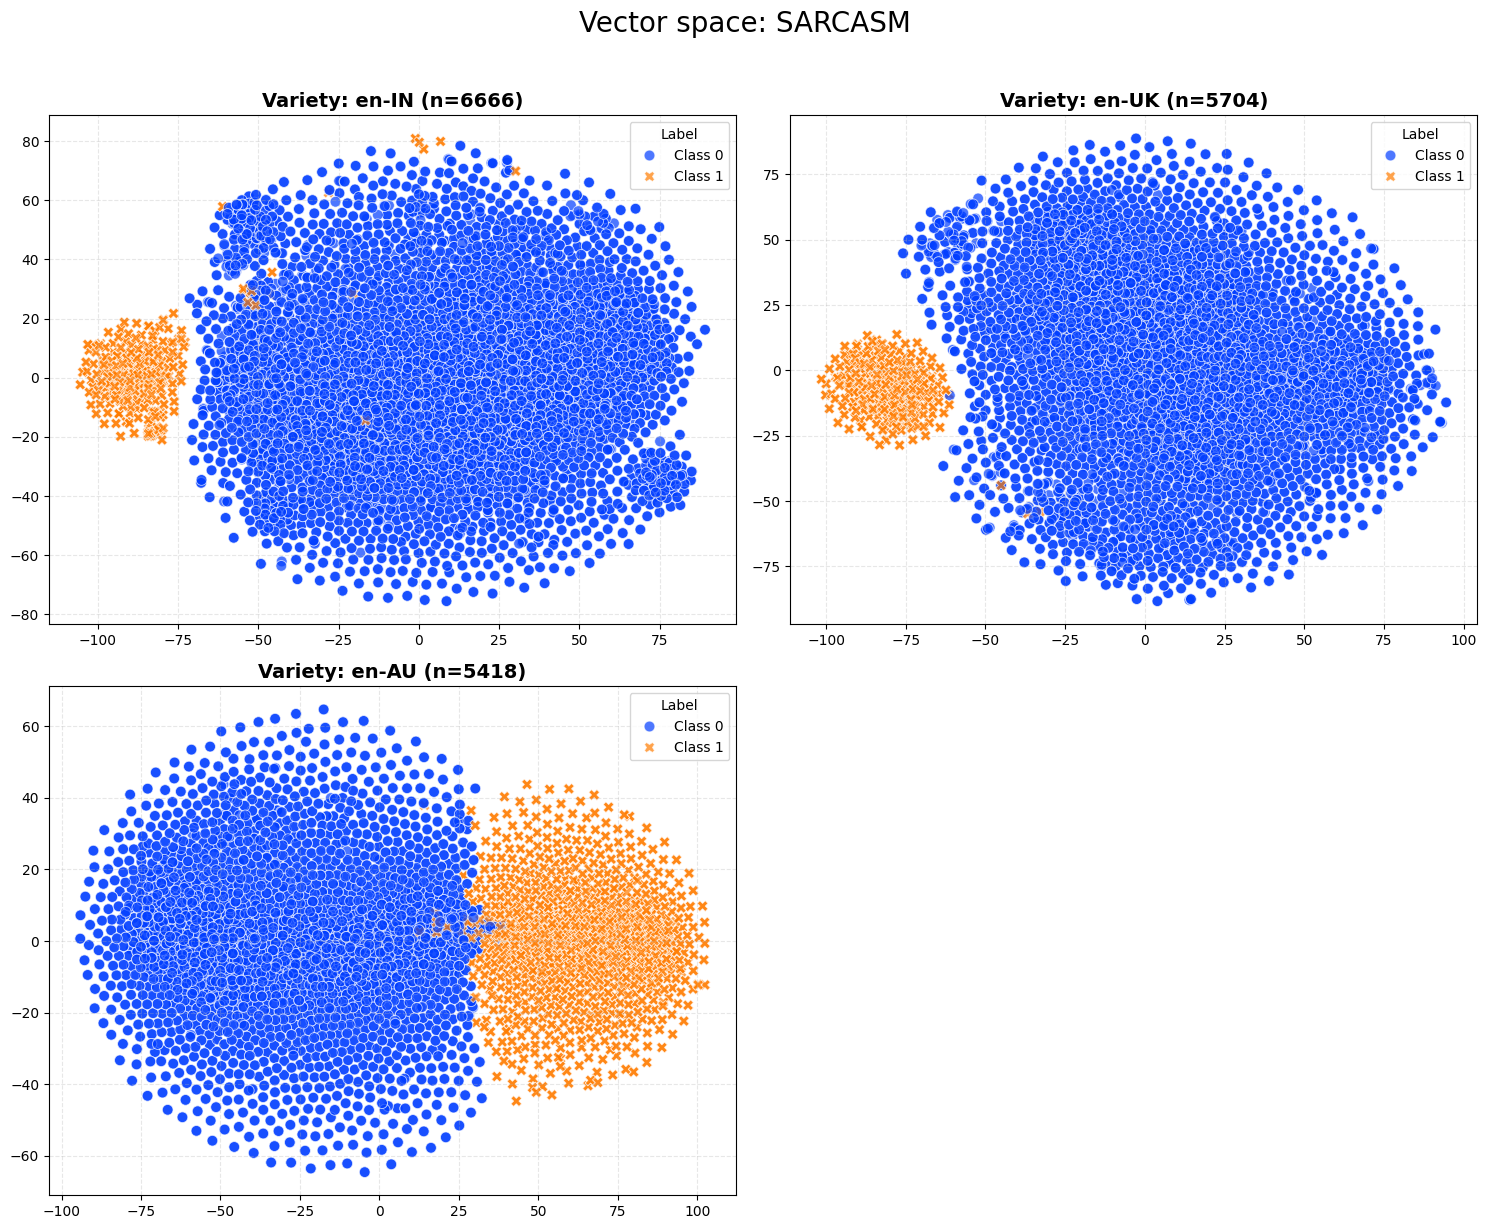

Graph saved in: /content/drive/MyDrive/DNLP project - Figurative Language Understanding/BERT_CL/Graphs/graph_dict_Sarcasm.png


In [14]:
embeddings_visualization("Sarcasm", all_embeddings)

#### Sentiment


Task: SENTIMENT


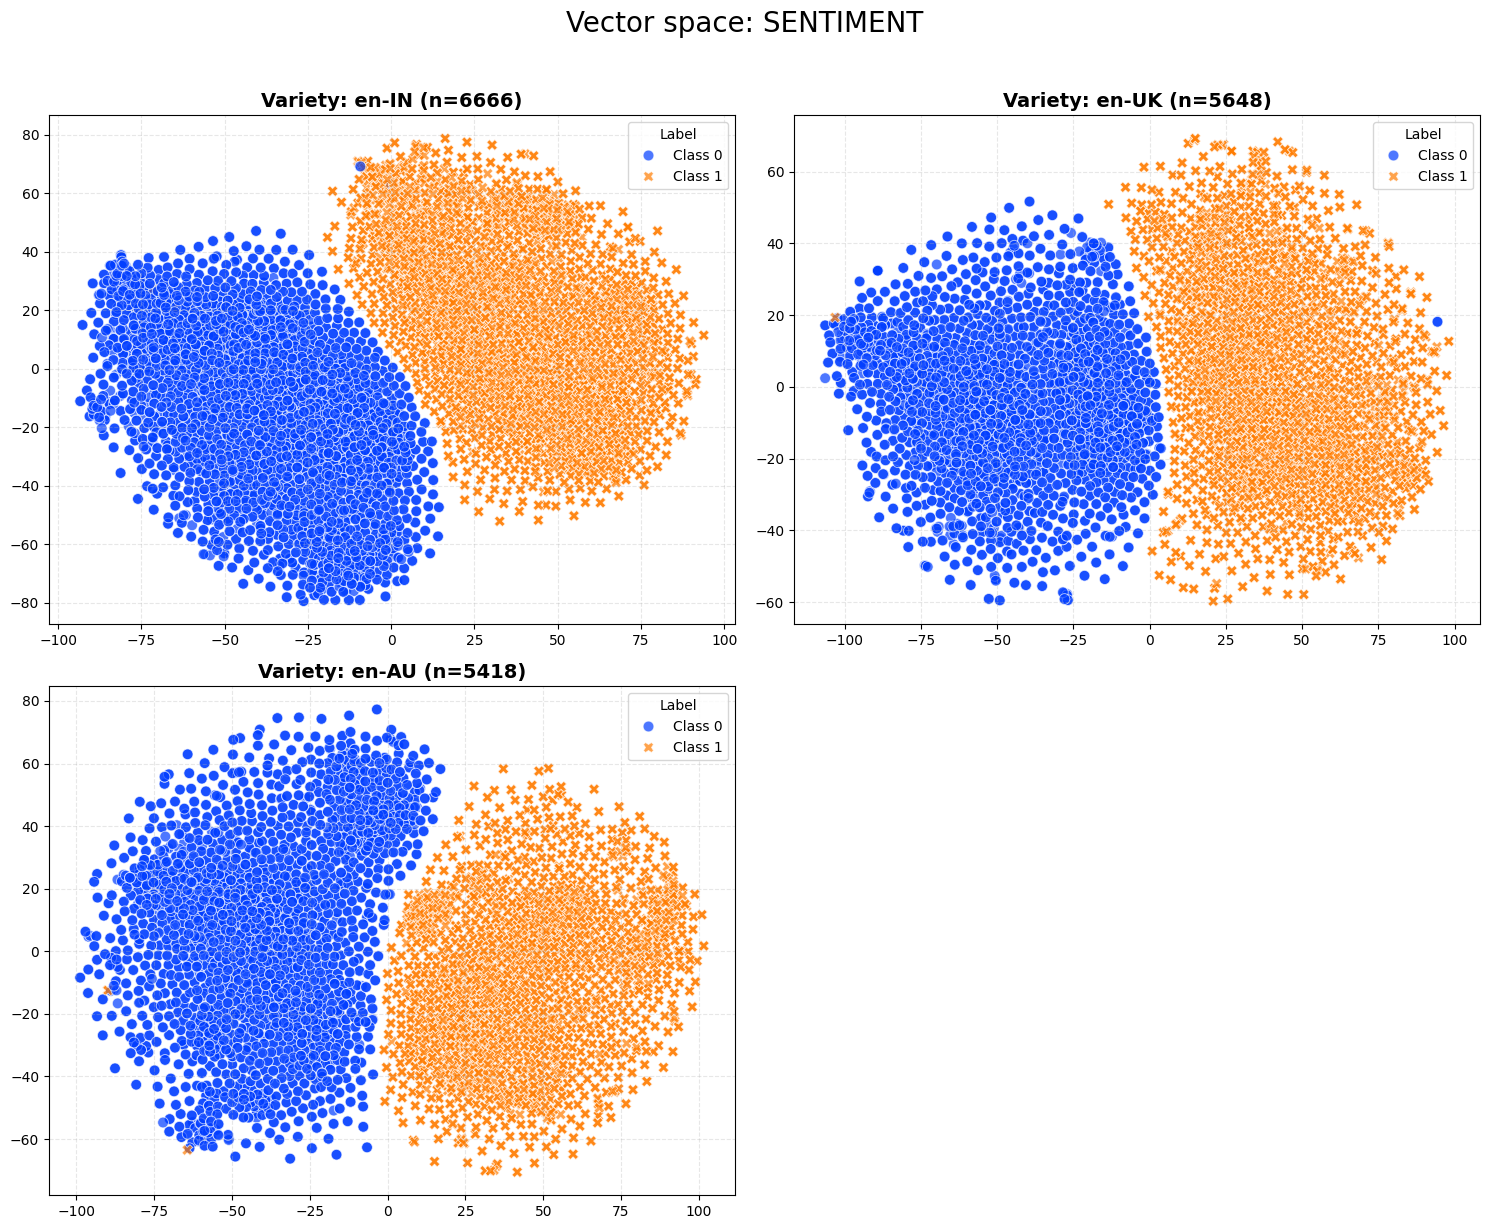

Graph saved in: /content/drive/MyDrive/DNLP project - Figurative Language Understanding/BERT_CL/Graphs/graph_dict_Sentiment.png


In [15]:
embeddings_visualization("Sentiment", all_embeddings)

### Competition

In [ ]:
OUTPUT_COMPETITION_DIR=f"{MODEL_PATH}/competition_models"
os.makedirs(OUTPUT_COMPETITION_DIR, exist_ok=True)

In [ ]:
def dataset_embeddig(df, task, variety, source):
    final_results = []

    groups = df.groupby(["task", "variety", "source"])
    group = df[
            (df["task"] == task) &
            (df["variety"] == variety) &
            (df["source"] == source)
    ]

    # compute embeddings

    bert_path = f"{MODEL_PATH}/{task}_{variety}"

    if not os.path.exists(bert_path):
        print(f"BERT model not found in: {bert_path}")
        return None, None

    try:
        bert_model = SentenceTransformer(bert_path)
        embeddings = bert_model.encode(group["text"].tolist(), show_progress_bar=False)
    except Exception as e:
        print(f"Error loading the model: {e}")
        return None, None

    if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return embeddings, group["label"].tolist()

In [ ]:
# Classifiers
classifiers = {
    "LogReg": LogisticRegression(
            max_iter=1000,
            random_state=SEED
    ),
    "SVM": SVC(
            kernel='rbf',
            C=1.0,
            probability=True,
            random_state=SEED
    ),
    "XGBoost": XGBClassifier(
            n_estimators=100,
            eval_metric='logloss',
            random_state=SEED
    ),
    "MLP": MLPClassifier(
            hidden_layer_sizes=(128, 64),
            max_iter=500,
            activation='relu',
            solver='adam',
            random_state=SEED
    )
}

#### Redistribution by source, for testing

In [ ]:
with open(DICT_PATH, "rb") as f:
    old_embeddings = pickle.load(f)

In [ ]:
newDict = f"{MODEL_PATH}/embeddings_by_source.pkl"

new_embeddings = {}

for task in old_embeddings:
    if task not in new_embeddings:
        new_embeddings[task] = {}

    for variety in old_embeddings[task]:
        print(f" Elaborazione: {task} - {variety}")

        data = old_embeddings[task][variety]
        X_all = data["X"]
        y_all = data["y"]
        texts_all = data["texts"]

        df_emb = pd.DataFrame({"text": texts_all})

        df_lookup = df_train[
            (df_train["task"] == task) &
            (df_train["variety"] == variety)
        ][["text", "source"]]

        df_lookup = df_lookup.drop_duplicates(subset=['text'])

        merged = df_emb.merge(df_lookup, on='text', how='left')

        merged['source'] = merged['source'].fillna('Unknown')

        sources_aligned = merged['source'].values
        unique_sources = np.unique(sources_aligned)

        new_embeddings[task][variety] = {}

        for source in unique_sources:
            mask = (sources_aligned == source)

            X_source = X_all[mask]
            y_source = y_all[mask]
            texts_source = [t for t, m in zip(texts_all, mask) if m]

            new_embeddings[task][variety][source] = {
                'X': X_source,
                'y': y_source,
                'texts': texts_source
            }

In [ ]:
# Saving
with open(newDict, "wb") as f:
    pickle.dump(new_embeddings, f)


#### Start classifiers competition

In [ ]:
newDict = f"{MODEL_PATH}/embeddings_by_source.pkl"

with open(newDict, "rb") as f:
    all_embeddings = pickle.load(f)

In [ ]:
results_list = []

print(f"{'Task':<12} | {'Variety':<15} | {"Source":<15} | {'Winner':<15} | {'Acc':<8} | {'F1-Score':<8}")
print("-" * 90)


for task in all_embeddings:
    for variety in all_embeddings[task]:
        for source in all_embeddings[task][variety]:

            data = all_embeddings[task][variety][source]
            X_train = data['X']
            y_train = data['y']

            X_test, y_test = dataset_embeddig(df_test, task, variety, source)

            if X_test is None:
                continue

            best_acc = 0
            best_model_name = ""
            best_clf_obj = None
            best_f1 = 0


            for clf_name, clf in classifiers.items():
                try:
                    # Training
                    clf.fit(X_train, y_train)

                    # Evaluation
                    preds = clf.predict(X_test)
                    acc = accuracy_score(y_test, preds)
                    f1 = f1_score(y_test, preds, average='binary')

                    # Updating scores
                    if f1 > best_f1:
                        best_acc = acc
                        best_f1 = f1
                        best_model_name = clf_name
                        best_clf_obj = clf
                except Exception as e:
                    print(f"Error qith {clf_name} on {variety}_{source}: {e}")

            print(f"{task} | {variety:<15} | {source:<15} | {best_model_name:<15} | {best_acc:.4%}   | {best_f1:.4%}")

            # Saving results and model
            results_list.append({
                'Task': task,
                'Variety': variety,
                'Source': source,
                'Best_Model': best_model_name,
                'Accuracy': best_acc,
                'F1_Score': best_f1,
                'Test_Samples': len(X_test)
            })

            filename = f"{task}_{variety}_{source }_{best_model_name}.joblib".replace(" ", "_")
            joblib.dump(best_clf_obj, os.path.join(OUTPUT_COMPETITION_DIR, filename))

Task         | Variety         | Source          | Winner          | Acc      | F1-Score
------------------------------------------------------------------------------------------


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sentiment | en-IN           | Google          | SVM             | 87.5556%   | 92.0000%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sentiment | en-IN           | Reddit          | LogReg          | 82.6087%   | 64.2857%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sentiment | en-UK           | Google          | LogReg          | 95.9677%   | 97.3545%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sentiment | en-UK           | Reddit          | SVM             | 96.3768%   | 82.7586%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sentiment | en-AU           | Google          | LogReg          | 94.6154%   | 96.4467%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sentiment | en-AU           | Reddit          | LogReg          | 89.2116%   | 83.3333%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sarcasm | en-IN           | Google          |                 | 0.0000%   | 0.0000%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sarcasm | en-IN           | Reddit          | MLP             | 88.2609%   | 37.2093%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metr

Sarcasm | en-UK           | Google          |                 | 0.0000%   | 0.0000%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sarcasm | en-UK           | Reddit          | LogReg          | 77.3050%   | 30.4348%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sarcasm | en-AU           | Google          | LogReg          | 90.0000%   | 13.3333%


Loading weights:   0%|          | 0/391 [00:00<?, ?it/s]

Sarcasm | en-AU           | Reddit          | XGBoost         | 71.7842%   | 69.0909%


In [ ]:
print("\nFinal results")
df_results = pd.DataFrame(results_list)

df_results = df_results.sort_values(by=['Task', 'F1_Score'], ascending=[True, True])

print(df_results)

# Saving results report
df_results.to_csv(f"{OUTPUT_COMPETITION_DIR}/best_models_results.csv", index=False)
print(f"Saved in'{OUTPUT_COMPETITION_DIR}'")


Final results
         Task Variety  Source Best_Model  Accuracy  F1_Score  Test_Samples
6     Sarcasm   en-IN  Google             0.000000  0.000000           225
8     Sarcasm   en-UK  Google             0.000000  0.000000           249
10    Sarcasm   en-AU  Google     LogReg  0.900000  0.133333           130
9     Sarcasm   en-UK  Reddit     LogReg  0.773050  0.304348           141
7     Sarcasm   en-IN  Reddit        MLP  0.882609  0.372093           230
11    Sarcasm   en-AU  Reddit    XGBoost  0.717842  0.690909           241
1   Sentiment   en-IN  Reddit     LogReg  0.826087  0.642857           230
3   Sentiment   en-UK  Reddit        SVM  0.963768  0.827586           138
5   Sentiment   en-AU  Reddit     LogReg  0.892116  0.833333           241
0   Sentiment   en-IN  Google        SVM  0.875556  0.920000           225
4   Sentiment   en-AU  Google     LogReg  0.946154  0.964467           130
2   Sentiment   en-UK  Google     LogReg  0.959677  0.973545           248
Saved in'/